In [330]:
import numpy as np
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor as SkExtraTreesRegressor
from sklearn.base import RegressorMixin
from sklearn.neural_network import MLPRegressor

from skopt.learning.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from skopt.optimizer import Optimizer
from skopt.space import Real, Integer
from tqdm import tqdm
import warnings

from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

warnings.filterwarnings("ignore", category=UserWarning)

In [331]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [16]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

In [332]:
warm_starts = 100  # Number of initial points

# Generate m initial points
warm_start_list = []
for _ in tqdm(range(warm_starts)):
    # warm_start, _ = cordex_continuous(runs=runs, f_list=n_x, scalars=0, optimality=optimality, J_cb=J_cb, final_pass_iter=3, epochs=3, main_bar=False)
    warm_start, _ = cordex_discrete(runs=runs, f_list=n_x, scalars=scalars, levels=[-1, 1], epochs=3, optimality=optimality, J_cb=J_cb, disable_bar=True)
    warm_start_flat = warm_start.flatten().reshape(1, -1).tolist()
    warm_start_list.extend(warm_start_flat)

100%|██████████| 100/100 [00:04<00:00, 23.35it/s]


In [333]:
def objective_function(X, m, n, J_cb=None):
    ones = np.ones((m, 1)).reshape(-1,1)
    X = np.array(X).reshape(m, n)
    Z = np.hstack((ones, X @ J_cb))
    try:
        M = np.linalg.inv(Z.T @ Z)
    except np.linalg.LinAlgError:
        return 1e10
    return np.trace(M)

In [334]:
# Parameters
n_iterations = 100  # Number of iterations for the optimization process
model_update_frequency = 5  # Update the GP model every 5 iterations
random_seed = 42  # Random seed for reproducibility

search_space = [Integer(-1, 1) for _ in range(runs * sum(n_x))]

# Create a Gaussian Process (GP) model with a Radial Basis Function (RBF) kernel
kernel = RBF(length_scale=1e-8)
# kernel = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, random_state=random_seed)
opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=5, acq_func="LCB", random_state=random_seed)

In [335]:
# f_val_list = []
# for point in tqdm(warm_start_list):
#     f_val = objective_function(point, runs, sum(n_x), J_cb=J_cb)
#     f_val_list.extend([f_val])
#     opt.tell(point, f_val)
# min(f_val_list)

In [336]:
f_val_list = []
for point in tqdm(warm_start_list):
    f_val = objective_function(point, runs, sum(n_x), J_cb=J_cb)
    f_val_list.extend([f_val])
    opt.tell(point, f_val)
min(f_val_list)

100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


8.69410240735889

In [311]:
# Bayesian Optimization loop
# kappa = 1e-6
for i in tqdm(range(150)):
    kappa = 0.01 * np.exp(-i / 20.0)
    opt.acq_func_kwargs = {'kappa': kappa}

    X_next = opt.ask()
    f_val = objective_function(X_next, runs, sum(n_x), J_cb=J_cb)
    opt.tell(X_next, f_val)

  0%|          | 0/150 [00:00<?, ?it/s]

<class 'list'>


TypeError: objective_function() missing 1 required positional argument: 'row_idx'

In [338]:
# Convert yi list to NumPy array
yi_array = np.array(opt.yi)
positive_yi_indices = np.where(yi_array > 0)
min_positive_yi_index = positive_yi_indices[0][np.argmin(yi_array[positive_yi_indices])]
optimal_X = opt.Xi[min_positive_yi_index]
optimal_matrix = np.array(optimal_X).reshape(runs, sum(n_x))
optimal_det = np.min(yi_array[positive_yi_indices])

In [339]:
np.round(yi_array,2).tolist()

[9.75,
 9.4,
 10.29,
 8.85,
 9.84,
 9.32,
 10.96,
 10.23,
 10.58,
 8.91,
 8.83,
 9.1,
 9.27,
 9.87,
 9.73,
 10.42,
 9.42,
 9.59,
 9.27,
 12.01,
 10.39,
 9.43,
 10.27,
 10.86,
 10.38,
 12.13,
 10.25,
 11.95,
 9.81,
 8.76,
 12.78,
 12.88,
 9.3,
 8.74,
 9.43,
 8.91,
 10.81,
 9.29,
 11.77,
 12.26,
 10.61,
 8.69,
 9.57,
 9.47,
 10.38,
 9.72,
 8.88,
 9.77,
 11.64,
 11.49,
 10.52,
 9.52,
 10.69,
 9.72,
 10.53,
 10.36,
 10.35,
 11.85,
 9.35,
 9.87,
 9.91,
 9.51,
 9.94,
 9.26,
 10.22,
 11.6,
 9.92,
 9.72,
 9.71,
 12.87,
 9.94,
 11.6,
 9.19,
 10.76,
 10.01,
 10.47,
 9.93,
 10.35,
 8.86,
 8.69,
 9.47,
 9.74,
 9.42,
 10.29,
 9.61,
 13.18,
 12.91,
 9.87,
 13.68,
 8.69,
 10.48,
 10.99,
 8.92,
 10.61,
 10.91,
 11.5,
 10.72,
 9.33,
 9.52,
 9.78,
 1194.74,
 550.72,
 138.91,
 610.76,
 175.01,
 18969.02,
 585.27,
 420.41,
 1279.44,
 174.17,
 402.64,
 103.09,
 4434.39,
 175.4,
 2272.92,
 171.07,
 2273.94,
 308.58,
 332.47,
 425.77,
 514.26,
 269.44,
 85.83,
 72.02,
 220.3,
 566.93,
 349.71,
 949.42,
 245.

In [340]:
print("Optimal Matrix X:")
print(optimal_matrix)
print("Minimum Determinant:")
print(optimal_det)

Optimal Matrix X:
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.]]
Minimum Determinant:
8.69410240735889


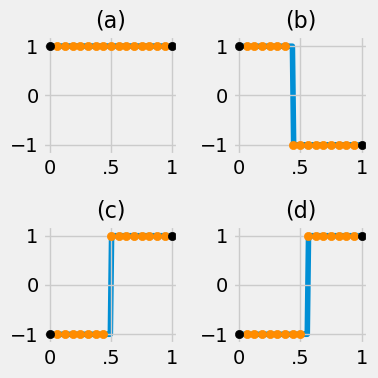

In [341]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=optimal_matrix)

In [204]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [16]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

In [211]:
class CustomExtraTreesRegressor(SkExtraTreesRegressor, RegressorMixin):
    def __init__(self, n_estimators=100, criterion="mse", max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0., max_features="auto",
                 max_leaf_nodes=None, min_impurity_decrease=0.,
                 bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0,
                 warm_start=False, ccp_alpha=0.0, max_samples=None):
        super().__init__(
            n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
            max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, bootstrap=bootstrap, oob_score=oob_score,
            n_jobs=n_jobs, random_state=random_state, verbose=verbose, warm_start=warm_start,
            ccp_alpha=ccp_alpha, max_samples=max_samples
        )

    def predict(self, X, return_std=False):
        if return_std:
            if self.criterion != "mse":
                raise ValueError(
                    "Expected impurity to be 'mse', got %s instead"
                    % self.criterion
                )
            mean = super().predict(X)
            std = np.std([tree.predict(X) for tree in self.estimators_], axis=0)
            return mean, std
        else:
            return super().predict(X)

In [212]:
warm_starts = 100  # Number of initial points

# Generate m initial points
warm_start_list = []
for _ in tqdm(range(warm_starts)):
    # warm_start, _ = cordex_continuous(runs=runs, f_list=n_x, scalars=0, optimality=optimality, J_cb=J_cb, final_pass_iter=3, epochs=3, main_bar=False)
    warm_start, _ = cordex_discrete(runs=runs, f_list=n_x, scalars=scalars, levels=[-1, 1], epochs=3, optimality=optimality, J_cb=J_cb, disable_bar=True)
    warm_start_flat = warm_start.flatten().reshape(1, -1).tolist()
    warm_start_list.extend(warm_start_flat)

100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


In [217]:
# Create the Bayesian optimization loop
n_calls = 100  # Number of optimization iterations
n_random_starts = 20  # Number of random initial points before fitting the surrogate model
et_model = CustomExtraTreesRegressor(n_estimators=100, random_state=0, criterion='mse')
opt = Optimizer(dimensions=[(-1.0, 1.0)] * (runs * sum(n_x)), base_estimator=et_model, n_initial_points=n_random_starts, acq_func='EI', random_state=0)

In [216]:
f_val_list = []
for point in tqdm(warm_start_list):
    f_val = objective_function(point, runs, sum(n_x), J_cb=J_cb)
    f_val_list.extend([f_val])
    opt.tell(point, f_val)
min(f_val_list)

 19%|█▉        | 19/100 [00:00<00:00, 84.23it/s]


ValueError: Expected impurity to be 'mse', got squared_error instead

In [151]:
# Perform the Bayesian optimization
for _ in tqdm(range(n_calls)):
    next_point = opt.ask()
    f_val = objective_function(next_point, runs, sum(n_x), J_cb=J_cb)
    opt.tell(next_point, f_val)

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [ ]:
# Get the best point found by the optimization process
best_point = opt.Xi[np.argmin(opt.yi)]
best_value = np.min(opt.yi)

print("Best point:", best_point)
print("Best value:", best_value)

---

In [266]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import MinMaxScaler
from skopt import Optimizer
from skopt.space import Real
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

def objective_function(x, m, n, J_cb=None):
    ones = np.ones((m, 1)).reshape(-1,1)
    X = np.array(x).reshape(m, n)
    Z = np.hstack((ones, X @ J_cb))
    try:
        M = np.linalg.inv(Z.T @ Z)
    except np.linalg.LinAlgError:
        return 1e10
    return np.trace(M)

runs = 12
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [16]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

np.random.seed(42)
X = np.random.rand(runs, sum(n_x))

scaler = MinMaxScaler()
X_transformed = scaler.fit_transform(X.reshape(-1, 1)).flatten()

search_space = [Real(-1, 1) for _ in range(runs * sum(n_x))]

kernel = Matern(nu=2.5)
gp_model = GaussianProcessRegressor(kernel=kernel)

optimizer = Optimizer(search_space, base_estimator=gp_model, n_initial_points=10, random_state=42)

n_iter = 50
for _ in tqdm(range(n_iter)):
    x_next = optimizer.ask()
    y_next = objective_function(x_next, runs, sum(n_x), J_cb=J_cb)
    optimizer.tell(x_next, y_next)
    print(y_next)
best_params = optimizer.X[np.argmin(optimizer.y)]
best_design_matrix = scaler.inverse_transform(np.array([best_params]).reshape(-1, 1)).reshape(runs, sum(n_x))


  0%|          | 0/50 [00:00<?, ?it/s]

78.90825175088109
27.217089710903707
61.69093854475875
287.10183865385784
202.54216294579055
47.44621677999155
114.1545972515674
94.43116654255478
64.89594593342329


 18%|█▊        | 9/50 [00:00<00:02, 19.80it/s]


TypeError: GaussianProcessRegressor.predict() got an unexpected keyword argument 'return_mean_grad'

In [308]:
import numpy as np
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
# from skopt.learning import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import RegressorMixin
from sklearn.neural_network import MLPRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, RBF, Matern
# from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel, WhiteKernel

from skopt.learning.gaussian_process.kernels import RBF
# from sklearn.gaussian_process.kernels import Matern
from skopt.optimizer import Optimizer
from skopt.space import Real, Integer
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

warnings.filterwarnings("ignore", category=UserWarning)

runs = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [16]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

def objective_function(X, m, n, row_idx, J_cb=None):
    X = np.array(X).reshape(1, n)
    X_full = update_X(X_full_initial, X, row_idx)
    ones = np.ones((m, 1)).reshape(-1,1)
    Z = np.hstack((ones, X_full @ J_cb))
    try:
        M = np.linalg.inv(Z.T @ Z)
    except np.linalg.LinAlgError:
        return 1e10
    return np.trace(M)

def update_X(X, new_row, row_idx):
    X_updated = X.copy()
    X_updated[row_idx] = new_row
    return X_updated

def smoothness_penalty(row, beta=1e-4):
    diff = np.diff(row)
    penalty = beta * np.sum(np.abs(diff))
    return penalty

def modified_objective_function(X, m, n, row_idx, J_cb=None, beta=1e-4):
    original_objective = objective_function(X, m, n, row_idx, J_cb=J_cb)
    current_row = np.array(X).reshape(1, n)

    penalty = smoothness_penalty(current_row, beta)
    return original_objective + penalty

def simple_oscillation(x, A, c, minimum):
    return A*np.cos((2*np.pi)/c*x) + minimum

def damped_oscillation(x, A, b, c, minimum):
    return A * np.exp(-b*x)*(1+np.sin((2*np.pi)/c*x)) + minimum

# Parameters
n_iterations = 50  # Number of iterations for the optimization process
model_update_frequency = 1  # Update the GP model every 5 iterations
random_seed = 42  # Random seed for reproducibility

# search_space = [Real(-1, 1) for _ in range(sum(n_x))]
search_space = [Real(-1, 1) for _ in range(sum(n_x))]

# Create a Gaussian Process (GP) model with a Radial Basis Function (RBF) kernel
kernel = RBF(length_scale=2.0, length_scale_bounds=(0.01, 100))
# kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.01, 100))
# kernel = Matern(length_scale=2.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, random_state=random_seed)

In [256]:
# opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=1, acq_func="LCB", random_state=random_seed)
# opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=model_update_frequency, acq_func="LCB", random_state=random_seed)
opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=model_update_frequency, acq_func="LCB", random_state=random_seed)

X_full_initial = np.random.choice([-1, 1], size=(runs, sum(n_x)))  # Initialize X_full with random values

A = 0.5 # starting position
b = 0.02 # decay rate
c = 10 # period
minimum = 1e-2 # minimum value


for row_idx in tqdm(range(runs)):
    # Bayesian Optimization loop for the current row
    for i in range(n_iterations):
        # kappa = damped_oscillation(i, A, b, c, minimum)
        # opt.acq_func_kwargs = {'kappa': kappa}

        X_next = opt.ask()
        f_val = objective_function(X_next, runs, sum(n_x), row_idx, J_cb=J_cb)
        opt.tell(X_next, f_val)

    # Update X_full_initial with the optimized row
    yi_array = np.array(opt.yi)
    positive_yi_indices = np.where(yi_array > 0)
    min_positive_yi_index = positive_yi_indices[0][np.argmin(yi_array[positive_yi_indices])]
    optimal_X = opt.Xi[min_positive_yi_index]
    X_full_initial = update_X(X_full_initial, optimal_X, row_idx)

    # Reset the optimizer for the next row
    # opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=1, acq_func="LCB", random_state=random_seed)
    opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=model_update_frequency, acq_func="LCB", random_state=random_seed)

optimal_matrix = np.array(X_full_initial)
optimal_det = np.min(yi_array[positive_yi_indices])

 25%|██▌       | 1/4 [00:04<00:12,  4.00s/it]


KeyboardInterrupt: 

In [309]:
n_restarts = 3  # Number of restarts for each row
opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=model_update_frequency, acq_func="LCB", random_state=random_seed)

for row_idx in tqdm(range(runs)):
    best_restart_obj_val = float('inf')
    best_restart_X = None

    for restart in range(n_restarts):
        # Bayesian Optimization loop for the current row
        for i in range(n_iterations):
            X_next = opt.ask()
            f_val = objective_function(X_next, runs, sum(n_x), row_idx, J_cb=J_cb)
            opt.tell(X_next, f_val)

        # Update X_full_initial with the optimized row if it's better than the previous best
        yi_array = np.array(opt.yi)
        positive_yi_indices = np.where(yi_array > 0)
        min_positive_yi_index = positive_yi_indices[0][np.argmin(yi_array[positive_yi_indices])]
        current_restart_X = opt.Xi[min_positive_yi_index]
        current_restart_obj_val = np.min(yi_array[positive_yi_indices])

        if current_restart_obj_val < best_restart_obj_val:
            best_restart_X = current_restart_X
            best_restart_obj_val = current_restart_obj_val

        # Reset the optimizer for the next restart
        opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=model_update_frequency, acq_func="LCB", random_state=random_seed)

    X_full_initial = update_X(X_full_initial, best_restart_X, row_idx)

100%|██████████| 4/4 [00:37<00:00,  9.30s/it]


In [263]:
optimal_matrix = X_full_initial
optimal_matrix

array([[-1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1],
       [ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [310]:
print(f'optimal: {np.round(optimal_det,2)}\niteration: {np.argmin(yi_array[positive_yi_indices])}')

optimal: 9.17
iteration: 0


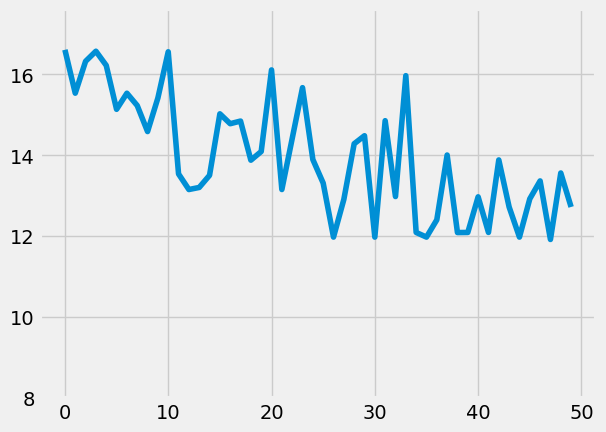

In [251]:
plt.plot(np.arange(n_iterations), yi_array)
# set y limits
plt.ylim(8, np.max(yi_array)+1)
plt.show()

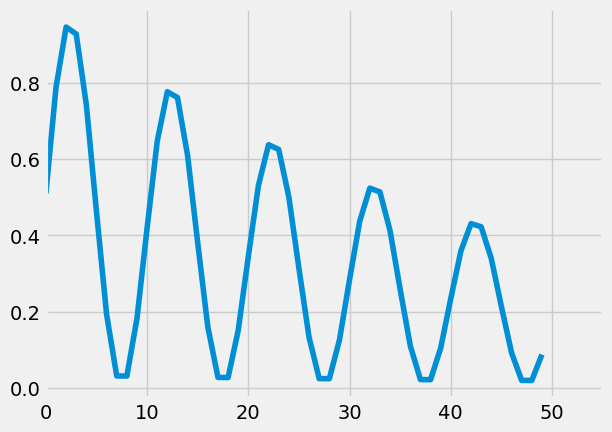

In [252]:
plt.plot(np.arange(n_iterations), damped_oscillation(x=np.arange(n_iterations), A=A, b=b, c=c, minimum=minimum))
# set x axis limits
plt.xlim(0, n_iterations+0.1*n_iterations)
plt.show()

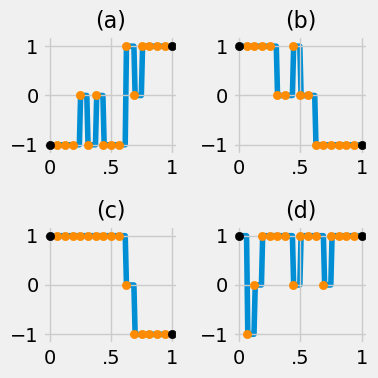

In [268]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=optimal_matrix)

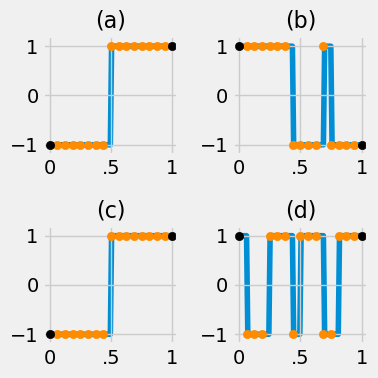

In [302]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=X_full_initial)

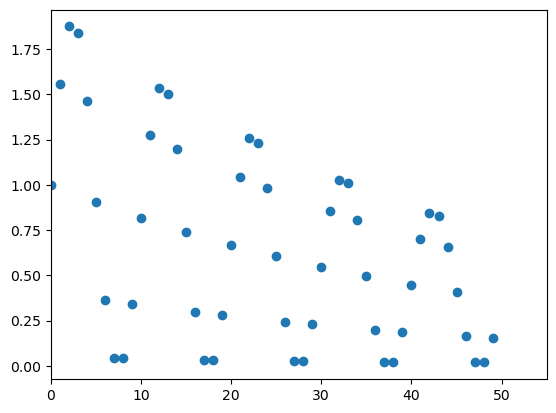

In [35]:
plt.scatter(np.arange(50), damped_oscillation(x=np.arange(50), A=1, b=0.02, c=10, minimum=minimum))
# set x axis limits
plt.xlim(0, 55)
plt.show()

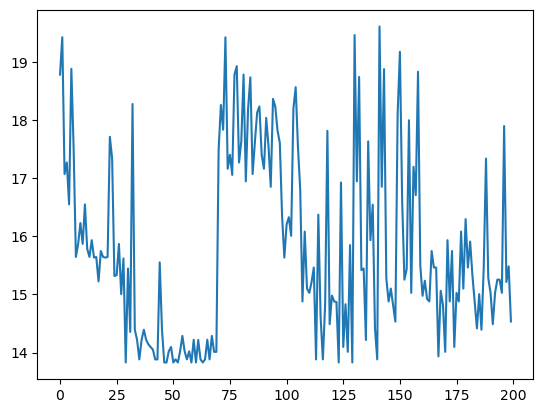